In [1]:
# Import the data!
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# --- Load all 5 coins ---
btc_data  = pd.read_csv("../historic_data/BTC_funding_data.csv",  parse_dates=["time"]).sort_values("time")
eth_data  = pd.read_csv("../historic_data/ETH_funding_data.csv",  parse_dates=["time"]).sort_values("time")
sol_data  = pd.read_csv("../historic_data/SOL_funding_data.csv",  parse_dates=["time"]).sort_values("time")
doge_data = pd.read_csv("../historic_data/DOGE_funding_data.csv", parse_dates=["time"]).sort_values("time")
kpepe_data= pd.read_csv("../historic_data/kPEPE_funding_data.csv",parse_dates=["time"]).sort_values("time")

In [2]:
n = 24 * 10  # 10 days ahead

# --- Target for all 5 coins ---
for df in (btc_data, eth_data, sol_data, doge_data, kpepe_data):
    df["future_funding_10d_mean"] = df["funding"].shift(-n).rolling(n, min_periods=n).mean()

# --- Drop NA for all 5 coins ---
btc_data   = btc_data.dropna()
eth_data   = eth_data.dropna()
sol_data   = sol_data.dropna()
doge_data  = doge_data.dropna()
kpepe_data = kpepe_data.dropna()

In [3]:
# --- Feature builder ---
n_2d, n_6d, n_18d = 24*2, 24*6, 24*18

def add_features(df):
    df = df.sort_values("time").copy()

    # Funding averages
    df["funding_avg_2d"]  = df["funding"].rolling(n_2d,  min_periods=n_2d).mean()
    df["funding_avg_6d"]  = df["funding"].rolling(n_6d,  min_periods=n_6d).mean()
    df["funding_avg_18d"] = df["funding"].rolling(n_18d, min_periods=n_18d).mean()

    # Premium averages
    df["premium_avg_2d"]  = df["premium"].rolling(n_2d,  min_periods=n_2d).mean()
    df["premium_avg_6d"]  = df["premium"].rolling(n_6d,  min_periods=n_6d).mean()
    df["premium_avg_18d"] = df["premium"].rolling(n_18d, min_periods=n_18d).mean()

    # Open interest averages
    # df["oi_avg_2d"]  = df["open_interest"].rolling(n_2d,  min_periods=n_2d).mean()
    # df["oi_avg_6d"]  = df["open_interest"].rolling(n_6d,  min_periods=n_6d).mean()
    # df["oi_avg_18d"] = df["open_interest"].rolling(n_18d, min_periods=n_18d).mean()

    return df

btc_data = add_features(btc_data)
eth_data = add_features(eth_data)
sol_data = add_features(sol_data)
doge_data = add_features(doge_data)
kpepe_data = add_features(kpepe_data)


In [4]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd


# Features / Target
featureCols = [
    "funding_avg_2d", "funding_avg_6d", "funding_avg_18d",
    "premium_avg_2d", "premium_avg_6d", "premium_avg_18d",
    # "oi_avg_2d", "oi_avg_6d", "oi_avg_18d",
]
targetCol = "future_funding_10d_mean"

def cleanAndSplitCoin(dfCoin: pd.DataFrame, coinName: str):
    dfCoin = dfCoin.dropna(subset=featureCols + [targetCol]).sort_values("time").copy()
    dfCoin["coin"] = coinName

    n = len(dfCoin)
    if n < 10:
        raise ValueError(f"{coinName}: not enough rows ({n}) to split train/val")

    n_train = int(round(n * 0.75))
    dfTrain = dfCoin.iloc[:n_train]
    dfVal   = dfCoin.iloc[n_train:]
    return dfTrain, dfVal



def reportMetrics(splitName: str, yTrue, yPred):
    mse = mean_squared_error(yTrue, yPred)
    mae = mean_absolute_error(yTrue, yPred)
    r2 = r2_score(yTrue, yPred)
    print(f"{splitName} -> MSE: {mse:.8f} | MAE: {mae:.8f} | R^2: {r2:.4f} | "
          f"Mean(y): {np.mean(yTrue):.8f} | Mean(ŷ): {np.mean(yPred):.8f}")

# Per-coin splits (BTC/ETH/SOL must exist)
btcTrain, btcVal = cleanAndSplitCoin(btc_data, "BTC")
ethTrain, ethVal = cleanAndSplitCoin(eth_data, "ETH")
solTrain, solVal = cleanAndSplitCoin(sol_data, "SOL")
dogeTrain, dogeVal = cleanAndSplitCoin(doge_data, "DOGE")
kpepeTrain, kpepeVal = cleanAndSplitCoin(kpepe_data, "kPEPE")


# Combine chronologically
trainAll = pd.concat([btcTrain,  ethTrain,  solTrain,  dogeTrain,  kpepeTrain], ignore_index=True).sort_values("time")
valAll   = pd.concat([btcVal,    ethVal,    solVal,    dogeVal,    kpepeVal  ], ignore_index=True).sort_values("time")

# Coin dummies (align across splits)
d_train = pd.get_dummies(trainAll["coin"], prefix="coin", drop_first=False)
d_val   = pd.get_dummies(valAll["coin"],   prefix="coin", drop_first=False)
all_cols = sorted(set(d_train.columns) | set(d_val.columns))
d_train = d_train.reindex(columns=all_cols, fill_value=0)
d_val   = d_val.reindex(columns=all_cols,   fill_value=0)

trainAll = pd.concat([trainAll.reset_index(drop=True), d_train.reset_index(drop=True)], axis=1)
valAll   = pd.concat([valAll.reset_index(drop=True),   d_val.reset_index(drop=True)],   axis=1)


featureCols = list(featureCols) + all_cols

# ---------- Single validation set (no blocks) ----------
# X/y
XTrain, yTrain = trainAll[featureCols], trainAll[targetCol]
XVal,   yVal   = valAll[featureCols],   valAll[targetCol]

# Scale (fit on train only)
scaler = StandardScaler()
XTrainScaled = scaler.fit_transform(XTrain)
XValScaled   = scaler.transform(XVal)


In [5]:
# ---------- Probe + staged early stopping on the single val set ----------

probe = GradientBoostingRegressor(
    n_estimators=600,
    learning_rate=0.02,
    max_depth=2,
    subsample=0.8,
    random_state=42
).fit(XTrainScaled, yTrain)

bestIter = 1
bestMae  = float("inf")
bestMse  = float("inf")

for i, yHat in enumerate(probe.staged_predict(XValScaled), start=1):
    mae = mean_absolute_error(yVal, yHat)
    mse = mean_squared_error(yVal, yHat)
    if mae < bestMae:
        bestMae, bestMse, bestIter = mae, mse, i
    if i % 100 == 0 or i == 1:
        print(f"Iter {i:4d}: MAE={mae:.6f} | MSE={mse:.8f}")

print(f"\n[Early Stopping] Best nEstimators: {bestIter}")
print(f"  Val MAE: {bestMae:.6f}")
print(f"  Val MSE: {bestMse:.8f}")

Iter    1: MAE=0.000020 | MSE=0.00000000
Iter  100: MAE=0.000011 | MSE=0.00000000
Iter  200: MAE=0.000010 | MSE=0.00000000
Iter  300: MAE=0.000010 | MSE=0.00000000
Iter  400: MAE=0.000010 | MSE=0.00000000
Iter  500: MAE=0.000011 | MSE=0.00000000
Iter  600: MAE=0.000011 | MSE=0.00000000

[Early Stopping] Best nEstimators: 148
  Val MAE: 0.000010
  Val MSE: 0.00000000


In [6]:
import os, json
from datetime import datetime
import joblib
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# === Refit on Train + ALL Validation (final fit for live use) ===
XTrVal = pd.concat([trainAll[featureCols], valAll[featureCols]], ignore_index=True)
yTrVal = pd.concat([trainAll[targetCol], valAll[targetCol]], ignore_index=True)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", GradientBoostingRegressor(
        n_estimators=max(1, bestIter),
        learning_rate=0.02,
        max_depth=2,
        subsample=0.8,
        random_state=42,
    )),
])

pipe.fit(XTrVal, yTrVal)

# === Save pipeline + metadata ===
os.makedirs("../models", exist_ok=True)
joblib.dump(pipe, "../models/gb_funding_pipeline.joblib")

meta = {
    "featureCols": list(featureCols),
    "targetCol": targetCol,
    "bestIter": int(bestIter),
    "trained_at_utc": datetime.utcnow().isoformat() + "Z",
}
with open("../models/gb_funding_meta.json", "w") as f:
    json.dump(meta, f, indent=2)

print("Saved: ../models/gb_funding_pipeline.joblib and ../models/gb_funding_meta.json")

# If you still want the raw objects for metrics below:
scalerFinal = pipe.named_steps["scaler"]
finalModel  = pipe.named_steps["model"]


# Combined validation metrics
yValPred = finalModel.predict(scalerFinal.transform(valAll[featureCols]))
reportMetrics("VAL (combined)", valAll[targetCol].values, yValPred)
print(
    f"VAL DirAcc: "
    f"{float(np.mean(np.sign(valAll[targetCol].values) == np.sign(yValPred))):.3f}"
)


# === Per-coin metrics ===
coin_order = ["BTC", "ETH", "SOL", "DOGE", "kPEPE"]

print("\n=== Validation RMSE per coin (original units) ===")
for sym in coin_order:
    dfc = valAll[valAll["coin"] == sym]
    if len(dfc) == 0:
        continue

    Xc_scaled = scalerFinal.transform(dfc[featureCols])
    y_true = dfc[targetCol].values
    y_pred = finalModel.predict(Xc_scaled)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{sym}: {rmse:.6e}")

print("\n=== Validation Directional Accuracy per coin (sign vs 0) ===")
eps = 0.0  # set >0 to treat tiny values as neutral

for sym in coin_order:
    dfc = valAll[valAll["coin"] == sym]
    if len(dfc) == 0:
        continue

    Xc_scaled = scalerFinal.transform(dfc[featureCols])
    y_true = dfc[targetCol].values
    y_pred = finalModel.predict(Xc_scaled)

    y_true_sign = np.sign(np.where(np.abs(y_true) <= eps, 0.0, y_true))
    y_pred_sign = np.sign(np.where(np.abs(y_pred) <= eps, 0.0, y_pred))
    dir_acc = (y_true_sign == y_pred_sign).mean()
    print(f"{sym}: {dir_acc:.3%}")


Saved: ../models/gb_funding_pipeline.joblib and ../models/gb_funding_meta.json
VAL (combined) -> MSE: 0.00000000 | MAE: 0.00000912 | R^2: 0.1148 | Mean(y): 0.00001116 | Mean(ŷ): 0.00001406
VAL DirAcc: 0.893

=== Validation RMSE per coin (original units) ===
BTC: 6.909095e-06
ETH: 9.159026e-06
SOL: 1.346918e-05
DOGE: 1.448071e-05
kPEPE: 1.754871e-05

=== Validation Directional Accuracy per coin (sign vs 0) ===
BTC: 100.000%
ETH: 93.986%
SOL: 81.149%
DOGE: 87.567%
kPEPE: 83.635%


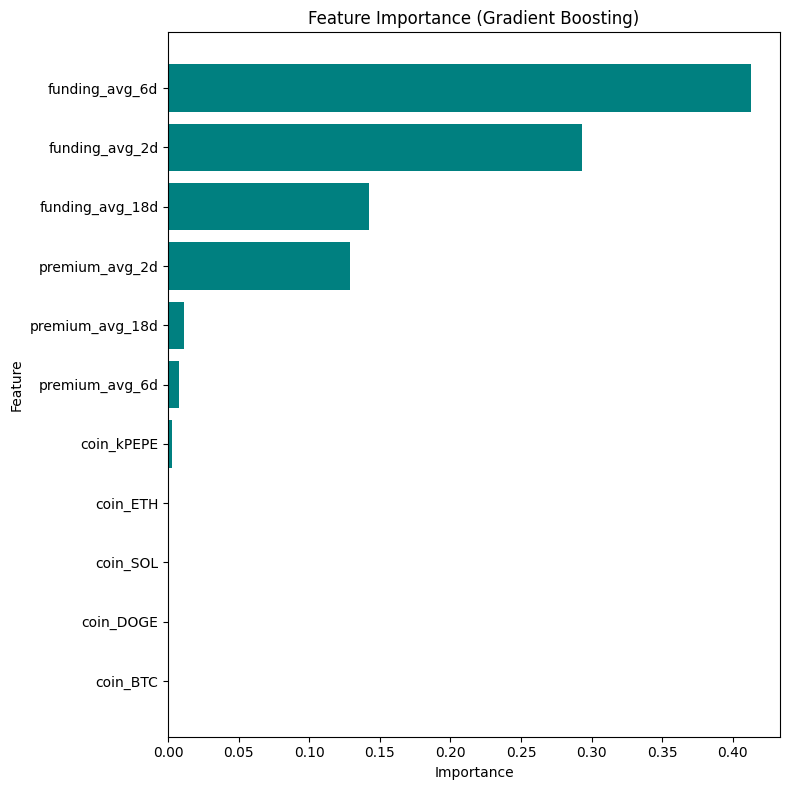

In [7]:
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# --- Feature importance plot ---
importances = finalModel.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8, 8))
plt.barh(np.array(featureCols)[indices], importances[indices], color="teal")
plt.title("Feature Importance (Gradient Boosting)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


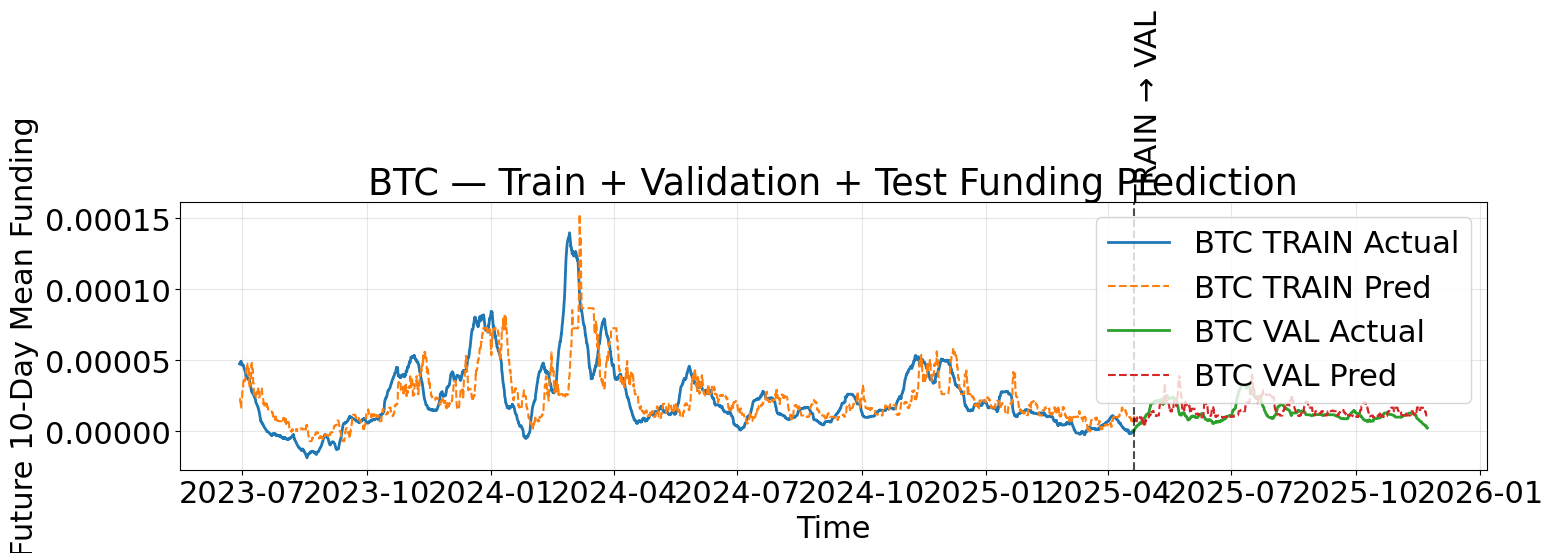

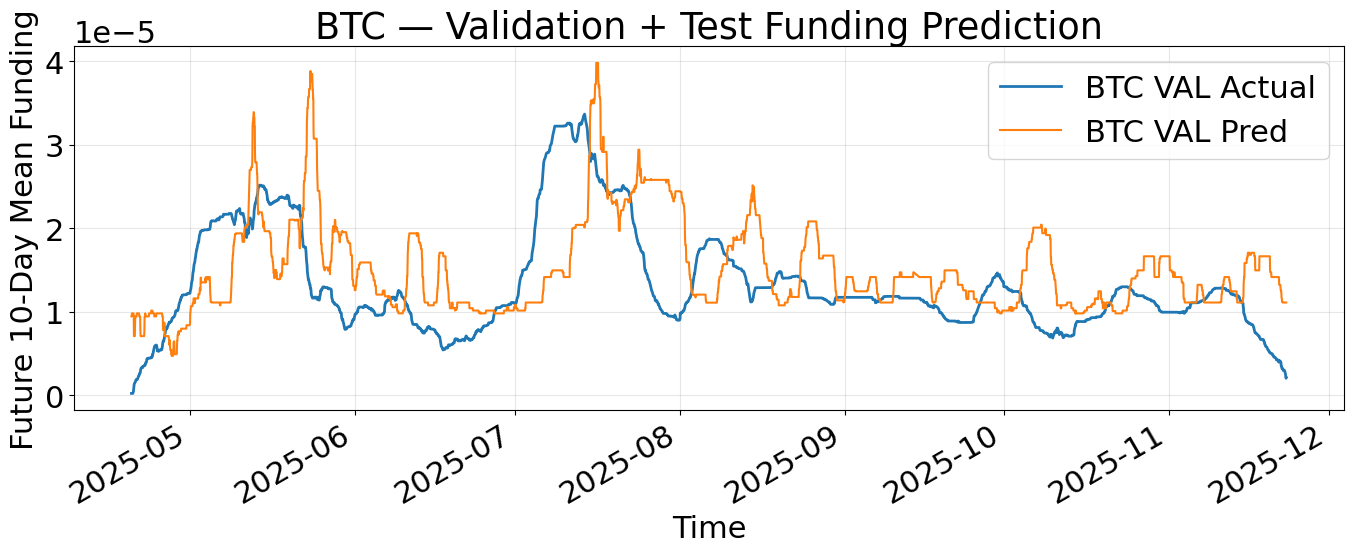

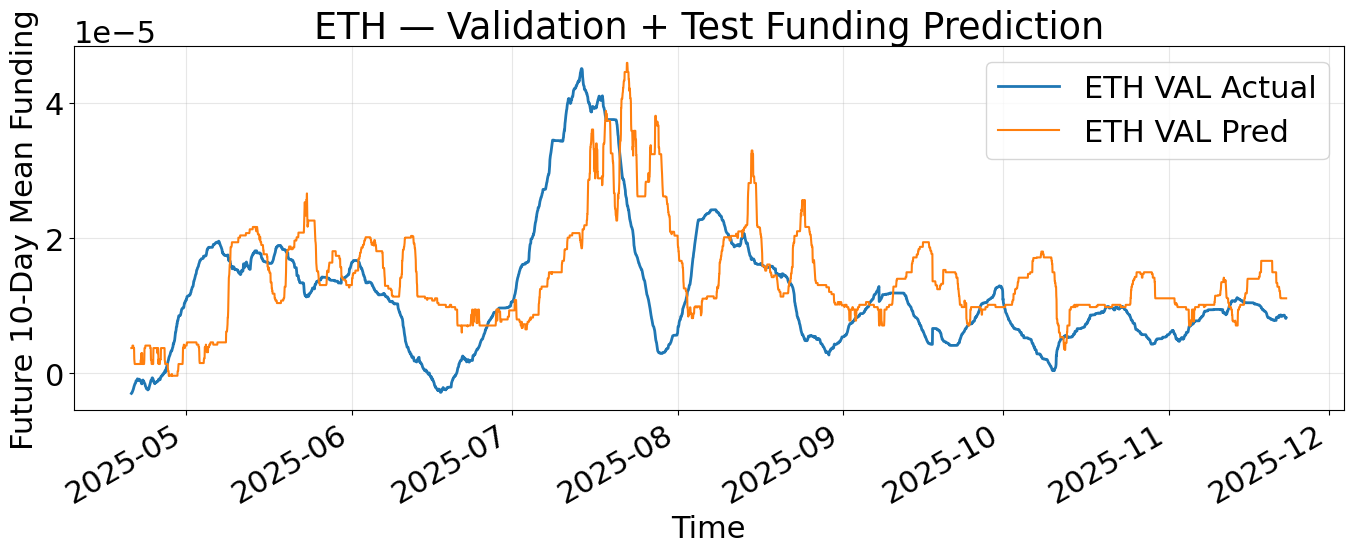

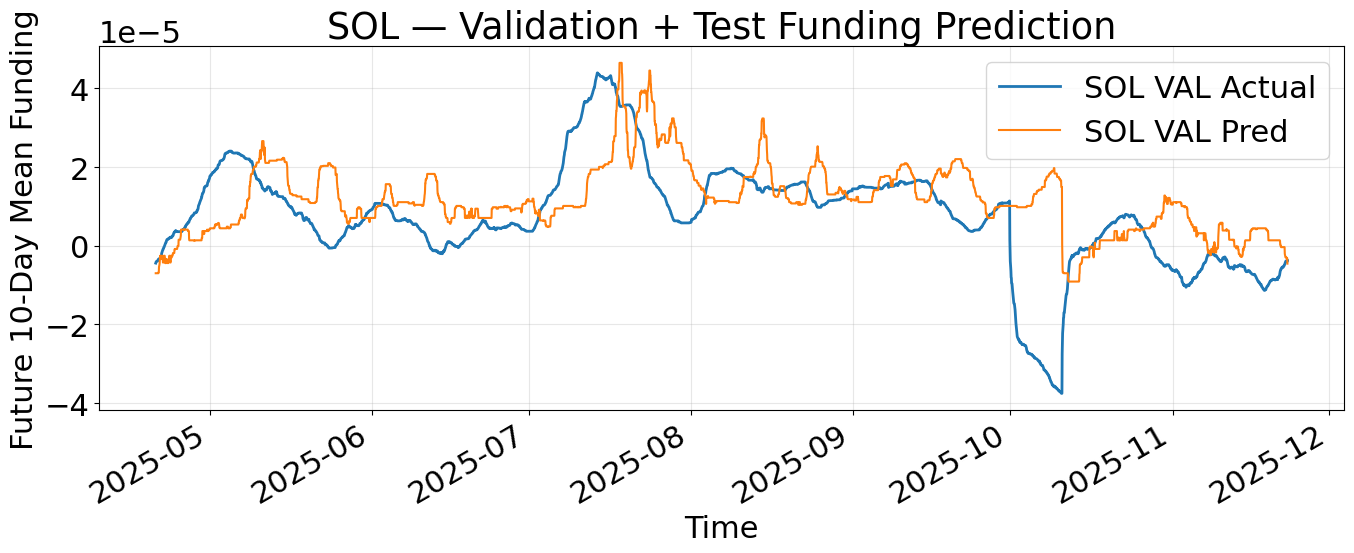

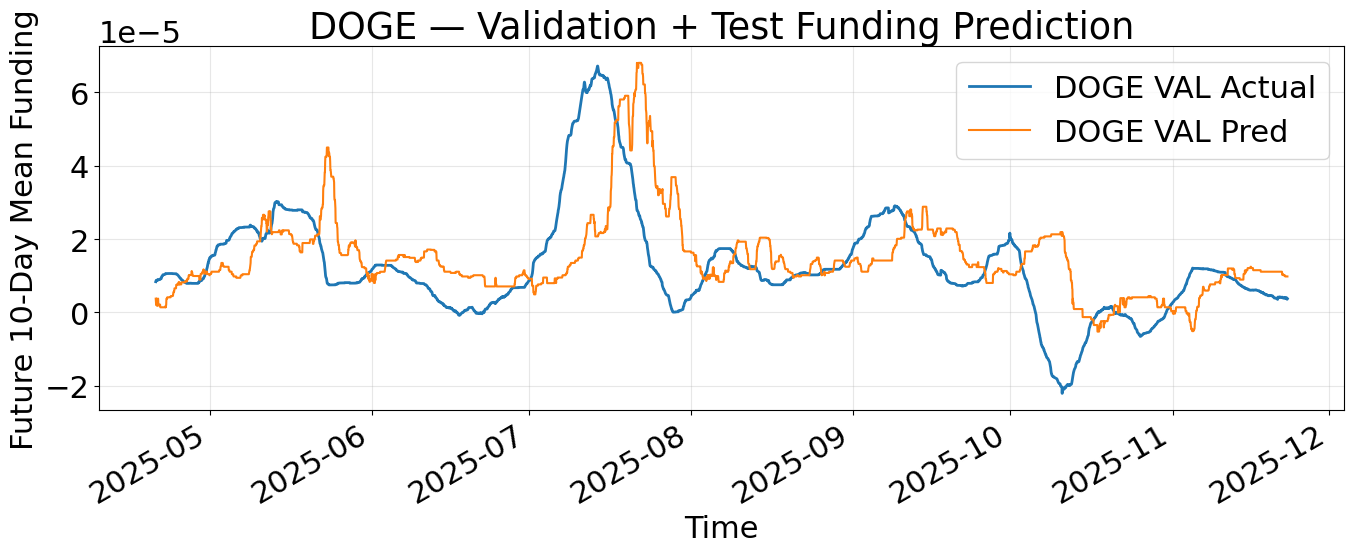

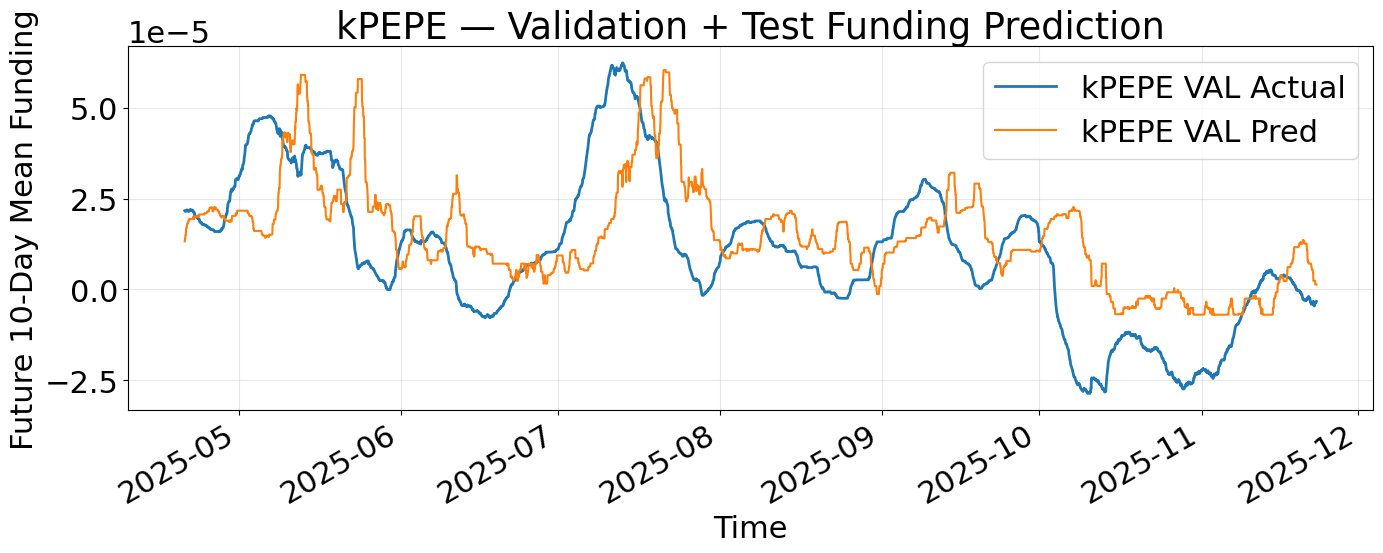

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["font.size"] = 22

btcTrain = trainAll[trainAll["coin"] == "BTC"]
btcVal   = valAll[valAll["coin"] == "BTC"]

btcTrainPred = finalModel.predict(scalerFinal.transform(btcTrain[featureCols])) if len(btcTrain) else np.array([])
btcValPred   = finalModel.predict(scalerFinal.transform(btcVal[featureCols]))   if len(btcVal)   else np.array([])

dfBTC = pd.concat([btcTrain, btcVal], ignore_index=True).copy()
dfBTC["yPred"] = np.r_[btcTrainPred, btcValPred] if len(dfBTC) else np.array([])


fig, ax = plt.subplots(figsize=(16, 6))
if len(btcTrain):
    ax.plot(btcTrain["time"], btcTrain[targetCol], label="BTC TRAIN Actual", linewidth=2)
    ax.plot(btcTrain["time"], btcTrainPred, "--", label="BTC TRAIN Pred")
if len(btcVal):
    ax.plot(btcVal["time"], btcVal[targetCol], label="BTC VAL Actual", linewidth=2)
    ax.plot(btcVal["time"], btcValPred, "--", label="BTC VAL Pred")
    ax.axvline(btcVal["time"].iloc[0], color="black", linestyle="--", alpha=0.7)
    ax.text(btcVal["time"].iloc[0], ax.get_ylim()[1], "TRAIN → VAL", rotation=90, va="bottom")

ax.legend(loc="upper right")
ax.set_title("BTC — Train + Validation + Test Funding Prediction")
ax.set_xlabel("Time"); ax.set_ylabel("Future 10-Day Mean Funding")
ax.grid(True, alpha=0.3)
fig.tight_layout()
plt.show()

# =========================
# 2) Per-coin plots: VAL + TEST only
# =========================
coin_order = ["BTC", "ETH", "SOL", "DOGE", "kPEPE"]
for coin in coin_order:
    dfv = valAll[valAll["coin"] == coin]

    yv_pred = finalModel.predict(scalerFinal.transform(dfv[featureCols])) if len(dfv) else np.array([])

    fig, ax = plt.subplots(figsize=(14, 6))
    if len(dfv):
        ax.plot(dfv["time"], dfv[targetCol], label=f"{coin} VAL Actual", linewidth=2)
        ax.plot(dfv["time"], yv_pred, label=f"{coin} VAL Pred")

    ax.legend(loc="upper right")
    ax.set_title(f"{coin} — Validation + Test Funding Prediction")
    ax.set_xlabel("Time"); ax.set_ylabel("Future 10-Day Mean Funding")
    ax.grid(True, alpha=0.3)
    plt.gcf().autofmt_xdate()
    fig.tight_layout()
    plt.show(block=True)
